In [1]:
import pandas as pd

# Read data
train = pd.read_csv('dengue_features_train.csv')
test = pd.read_csv('dengue_features_test.csv')
labels = pd.read_csv('dengue_labels_train.csv')

# *Cleaning data*

In [2]:
# Convert week_start_date to datetime object
train['week_start_date'] = pd.to_datetime(train['week_start_date'])

In [3]:
# Putting week_start_date to become index
train.index = train['week_start_date']

In [4]:
# Splitting cities
train_sj = train[train['city'] == 'sj'].copy()
train_iq = train[train['city'] == 'iq'].copy()

In [5]:
# Merging train and labels data
train_sj = train_sj.merge(labels, on=['city', 'year', 'weekofyear'])

In [6]:
# Setting datetime index
train_sj.index = train_sj['week_start_date']

In [7]:
# Merging train and labels data
train_iq = train_iq.merge(labels, on=['city', 'year', 'weekofyear'])

In [8]:
# Setting datetime index
train_iq.index = train_iq['week_start_date']

# *Imputing Nans*

In [9]:
# Only columns with missing values
nans_columns = train_sj.columns[4:]
nans_columns_iq = train_iq.columns[4:]

train_sj_nans = train_sj.drop(columns=['city', 'year', 'weekofyear', 'week_start_date']).copy()
train_iq_nans = train_iq.drop(columns=['city', 'year', 'weekofyear', 'week_start_date']).copy()

In [10]:
# Imputing with linear interpolation
linear_sj = train_sj[nans_columns].interpolate(method='linear')
linear_iq = train_iq_nans.interpolate(method='linear')

# *Model*

In [11]:
from sklearn.svm import SVR

predictors = ['reanalysis_specific_humidity_g_per_kg', 'ndvi_nw']
target = 'total_cases'

# Splitting train and test data
train_data = linear_sj.iloc[:-100].copy()
test_data = linear_sj.iloc[-100:].copy()

# Initializing model
svm = SVR(kernel='linear',
         C=20,
         tol=17,
         epsilon=0.05,
         shrinking=True)

svm.fit(train_data[predictors], train_data[target])
preds = svm.predict(test_data[predictors])

In [12]:
from sklearn.metrics import mean_absolute_error

# Measuring mean absolute error
mean_absolute_error(test_data[target], preds)

16.03824675025699

In [13]:
# Feature correlation
pd.Series(svm.coef_.flatten(), index=predictors).sort_values()

reanalysis_specific_humidity_g_per_kg     2.307929
ndvi_nw                                  21.974422
dtype: float64

# *Diagnostics*

In [14]:
# Concatenating actual values and predictions
combined = pd.concat([test_data[target], pd.Series(preds, index=test_data.index)], axis=1)
combined.columns = ['actual', 'predictions']

In [15]:
combined

,actual,predictions
week_start_date,,
2006-05-28,11,15.183352
2006-06-04,5,16.959857
2006-06-11,5,16.941836
2006-06-18,6,16.107004
2006-06-25,6,19.012578
...,...,...
2008-03-25,4,6.932336
2008-04-01,3,9.790003
2008-04-08,1,7.896247


Text(0.5, 1.0, 'SJ city')

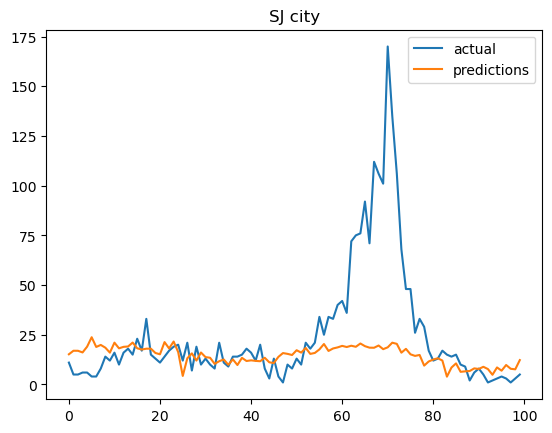

In [16]:
import matplotlib.pyplot as plt

# Plotting actual vs predictions
combined.reset_index().drop(columns=['week_start_date']).plot()
plt.title('SJ city')

In [23]:
from sklearn.svm import SVR

predictors = ['reanalysis_specific_humidity_g_per_kg', 'ndvi_nw']
target = 'total_cases'

# Splitting train and test data
train_data_iq = linear_iq.iloc[:-100].copy()
test_data_iq = linear_iq.iloc[-100:].copy()

# Initializing model
svm = SVR(kernel='linear',
         C=20,
         tol=17,
         epsilon=0.05,
         shrinking=True)

svm.fit(train_data_iq[predictors], train_data_iq[target])
preds_iq = svm.predict(test_data_iq[predictors])

In [24]:
# Measuring mean absolute error
mean_absolute_error(test_data_iq[target], preds_iq)

7.010818210974366

In [25]:
# Feature correlation
pd.Series(svm.coef_.flatten(), index=predictors).sort_values()

reanalysis_specific_humidity_g_per_kg    1.114286
ndvi_nw                                  1.226800
dtype: float64

# *Diagnostics for IQ*

In [26]:
# Concatenating actual values and predictions
combined_iq = pd.concat([test_data_iq[target], pd.Series(preds_iq, index=test_data_iq.index)], axis=1)
combined_iq.columns = ['actual', 'predictions']

In [27]:
combined_iq

,actual,predictions
week_start_date,,
2008-07-29,5,5.969678
2008-08-05,2,6.058278
2008-08-12,5,6.047099
2008-08-19,5,4.943852
2008-08-26,5,5.691678
...,...,...
2010-05-28,5,7.732941
2010-06-04,8,7.075233
2010-06-11,1,5.874938


Text(0.5, 1.0, 'IQ city')

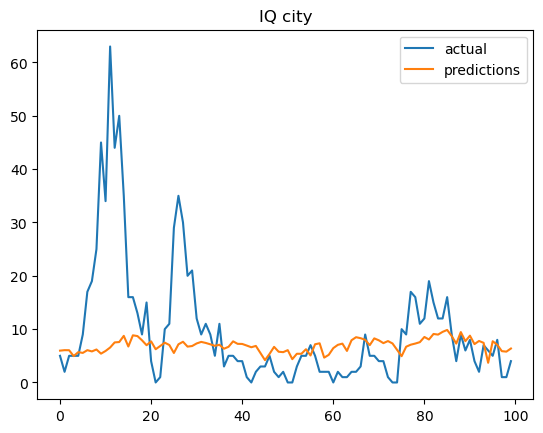

In [30]:
# Plotting actual vs predictions
combined_iq.reset_index().drop(columns=['week_start_date']).plot()
plt.title('IQ city')